In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute

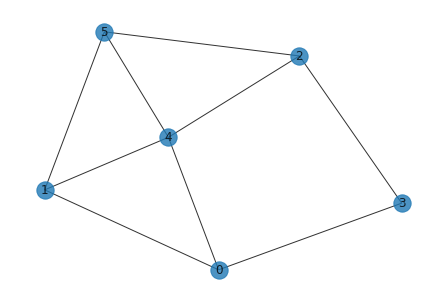

In [2]:
edges = [(0,1), (0,4), (0,3), (1,4), (1,5), (2,3), (2,4), (2,5), (4,5)]
G = nx.Graph(edges)
nx.draw(G, with_labels=True, alpha=0.8)

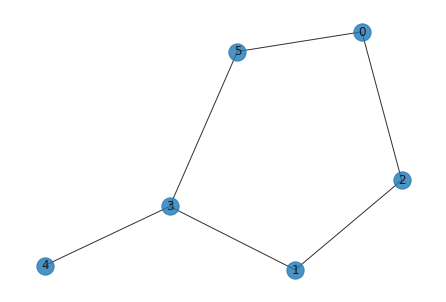

In [3]:
# function to find edges that don't exist
non_edges = []
for i in range(len(nx.nodes(G))):
    for j  in range(i):
        if i!=j :
            non_edges.append((j,i))
for i in range(len(edges)):
    non_edges.remove(edges[i])
non_G = nx.Graph(non_edges)
nx.draw(non_G, with_labels=True, alpha=0.8)

In [4]:
def max_clique(x, G):
    # x is the input bit string
    # Output will be the maxcut function value using x bit string
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
    return obj

In [5]:
 def create_qaoa_circ(G, theta):   
    nqubits = len(G.nodes()) 
    qc = QuantumCircuit(nqubits)
    clauses = len(G.edges())
    nlayers = len(theta)//((nqubits*2)+clauses)
    beta = np.reshape(theta[:nlayers*nqubits], (nlayers,nqubits))
    gamma = np.reshape(theta[nlayers*nqubits:], (nlayers,nqubits+clauses))
    
    for i in range(nqubits):
        qc.h(i)
    
    for irep in range(nlayers):
        k=0
        # problem unitary
        for i in range(nqubits):
            qc.rz(2 * gamma[irep,k], i)
            k+=1
        
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep,k], pair[0], pair[1])
            qc.barrier()
            k+=1
        
        # mixer unitary
        for i in range(nqubits):
            qc.rx(2 * beta[irep,i], i)
        
    qc.measure_all()
    return qc

In [6]:
def compute_expectation(counts, G):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = max_clique(bitstring, G)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [7]:
def get_expectation(G, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
        return compute_expectation(counts, G)
    
    return execute_circ

[2 3 4 2 3 2 4 3 5 3 3 5 2 3 4 3 2 4 4 3 3 4 4 3 4 4 3 4 2 3 4 4 2 3 3 3]


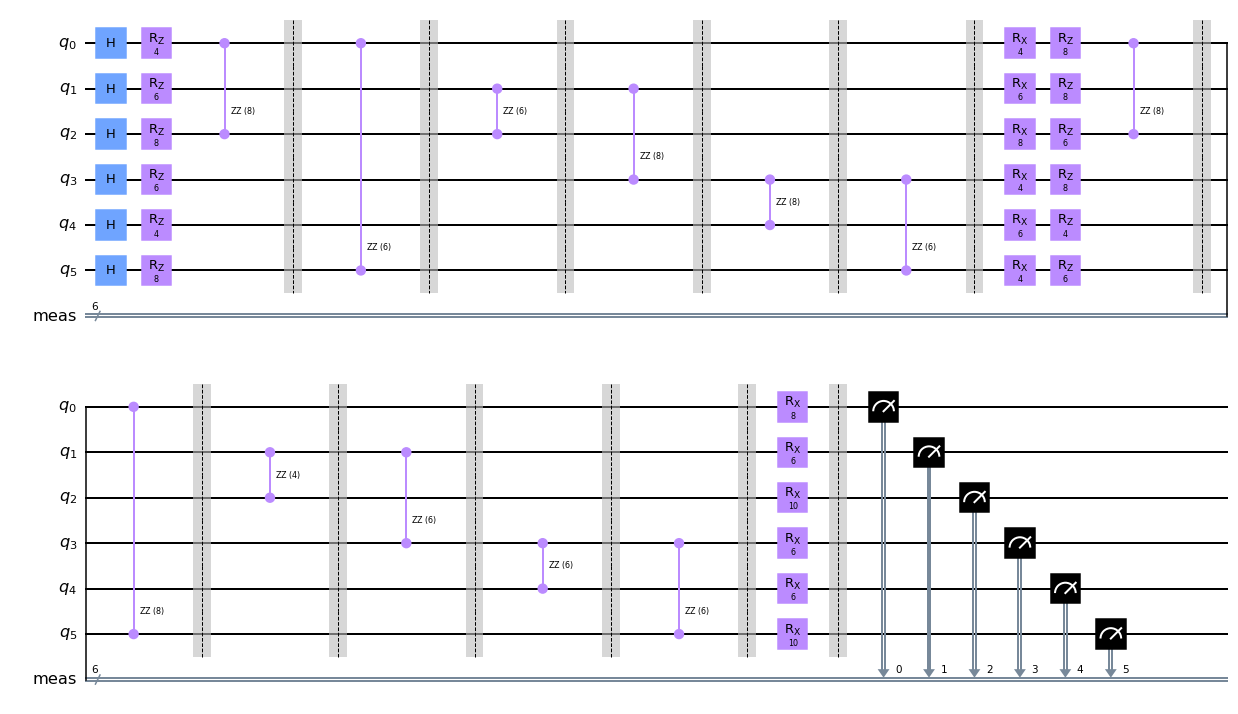

In [13]:
# Adding Parameters
beta = np.array([[2,3,4,2,3,2], [4,3,5,3,3,5]]) #Edit as per the number of qubits
gamma = np.array([[2,3,4,3,2,4,4,3,3,4,4,3],[4,4,3,4,2,3,4,4,2,3,3,3]]) #Edit as per the number of (qubits + the combination nC2 - number of edges)
theta = np.concatenate((beta.flatten(), gamma.flatten()))

qc = create_qaoa_circ(non_G, theta)
print(theta)
qc.draw()

In [14]:
from scipy.optimize import minimize
expectation = get_expectation(non_G)
res = minimize(expectation, theta, method='COBYLA')
res

     fun: -4.943359375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 394
  status: 1
 success: True
       x: array([2.08871499, 3.64756207, 3.89919659, 3.0477177 , 3.24666718,
       2.05408133, 3.90535593, 4.21218506, 4.90071659, 4.04705179,
       3.95232195, 4.702654  , 1.60061562, 2.74584773, 3.74213152,
       2.86541333, 1.81960861, 3.85759236, 4.83627721, 3.15827704,
       3.09789496, 4.87767187, 4.97925181, 3.37978582, 3.8208795 ,
       4.03230458, 3.82164626, 5.0424219 , 2.08601752, 3.06071968,
       3.58365436, 4.26160498, 3.08488481, 2.93009614, 2.8425292 ,
       3.06801161])

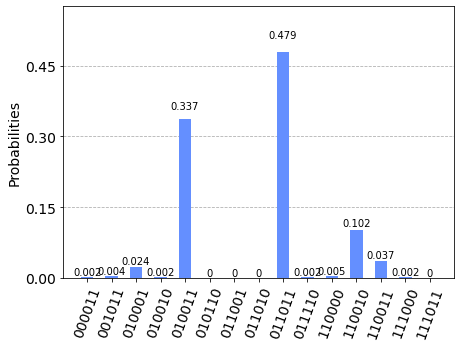

In [15]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(non_G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)